## Problem Statement

Accurate and timely rainfall prediction is crucial for planning and decision-making in agriculture, transportation, and daily life. In this project, I aim to build a machine learning classifier that predicts whether it will rain **today** using historical weather data up to and including **yesterday**. This simulates a real-world use case where individuals or organizations must make early-day decisions such as whether to carry an umbrella, irrigate crops, or cancel an event.

To ensure practicality and avoid data leakage, I will use only information that would be realistically available by the start of the day.

## Project Objective

The objective of this project is to apply a complete machine learning workflow to a real-world weather dataset and:

- Explore and clean the dataset for inconsistencies and missing values
- Perform feature engineering to improve predictive power
- Use historical weather data to train a classifier to predict rainfall
- Implement and evaluate classification models including Logistic Regression and Random Forest
- Tune model hyperparameters using Grid Search with cross-validation
- Interpret performance using metrics such as accuracy, precision, recall, and confusion matrix
- Ensure that all model decisions are made using only data available up to the prediction time (no future leakage)

The final deliverable will be a trained model capable of predicting whether it will rain **today**, based solely on past weather observations.

## Dataset Introduction

The dataset contains daily weather observations from various Australian locations between **2008 and 2017**. Each row represents a single day's weather report and includes meteorological variables such as temperature, rainfall, wind speed, humidity, pressure, and sunshine levels.

Key details:
- **Time Range**: 2008–2017
- **Granularity**: Daily observations
- **Target Variable**: `RainToday` (after renaming from `RainTomorrow`)
- **Input Features**: Weather-related metrics available up to the day before prediction

This dataset provides an excellent opportunity to train a binary classifier under realistic operational constraints for rainfall prediction.

### Import All Required Libraries

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set(style='whitegrid')

### Load and Inspect the Dataset

In [10]:
# Load the dataset
df = pd.read_csv("weatherAUS.csv")

# Displaying basic info
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [13]:
# Summary of data types and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [15]:
# Quick look at missing values
df.isnull().sum().sort_values(ascending=False).head(10)

Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
dtype: int64

#### Drop Rows with any missing values

In [24]:
# Drop all rows with any missing values
df.dropna(inplace=True)

# Confirming shape after drop
print("Data shape after dropping missing values:", df.shape)

Data shape after dropping missing values: (56420, 23)


In [26]:
# Rename columns to avoid future-leakage
df.rename(columns={
    'RainToday': 'RainYesterday',
    'RainTomorrow': 'RainToday'
}, inplace=True)

## Avoiding Data Leakage: Redefining the Target

In a real-world scenario, we want to predict whether it will rain **today** using information that is available **before or at the start of the day**. 

Originally, the dataset includes a `RainTomorrow` column, which indicates whether it rained **after the day ends**. Since we won't know the future in reality, using this as the target would cause **data leakage**.

Instead, I:
- Renamed `RainTomorrow` → `RainToday` (my **new target**)
- Renamed `RainToday` → `RainYesterday` (used as a feature)

This ensures my model mimics a **real use case**, such as:
> _"Should I take my umbrella today based on yesterday's weather and current conditions?"_

## Features That Cause Leakage or Are Inefficient for RainTomorrow

### Why Predicting "RainTomorrow" is Impractical

Several features in the dataset include measurements **taken throughout the day**, such as:

- `Temp3pm`, `Humidity3pm`, `WindSpeed3pm`
- `RainToday` (now renamed as `RainYesterday`)

If I tried to predict `RainTomorrow` using these, I would be **using future data** that wouldn’t be available in the morning.

Hence, it would **not be realistic** to build a model around that target without violating proper ML principles.

## Localizing the Model to Melbourne Region
### Focusing on a Local Region

Weather patterns vary significantly across regions. For example, a city in a tropical zone will have very different rainfall behavior than one in a dry inland area.

To reduce this complexity, I limit my model to observations from **only three nearby locations** in the Melbourne area:

- Melbourne
- MelbourneAirport
- Watsonia

These cities are geographically close (within ~15–20 km), making the model’s task more focused and realistic. I also **keep `Location` as a feature** so that the model can still learn subtle local patterns within this small region.


In [40]:
# Filter data for Melbourne region only
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia'])]

# Checking updated shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

In [44]:
df['Date'] = pd.to_datetime(df['Date'])

In [50]:
# Defining the function
def date_to_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

## Creating a Seasonal Feature from the Date

Weather patterns are heavily influenced by seasonal changes, so it’s important to extract a **"Season"** feature from the `Date` column. This will help my model learn patterns that differ between summer, winter, autumn, and spring.

Since raw date values are not directly useful for prediction, I follow these steps:

1. **Convert the `Date` column** into `datetime` format (if not already).
2. **Define a function** that maps each month to a season:
   - December, January, February = Summer
   - March, April, May = Autumn
   - June, July, August = Winter
   - September, October, November = Spring
3. **Apply the function** to the `Date` column to create a new column called `Season`.
4. **Drop the original `Date` column**, as it's no longer needed.

This transformation allows the model to consider seasonal effects without leaking any future-specific time information.

In [52]:
# Apply function to create Season column
df['Season'] = df['Date'].apply(date_to_season)

# Drop original Date column
df.drop(columns='Date', inplace=True)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer


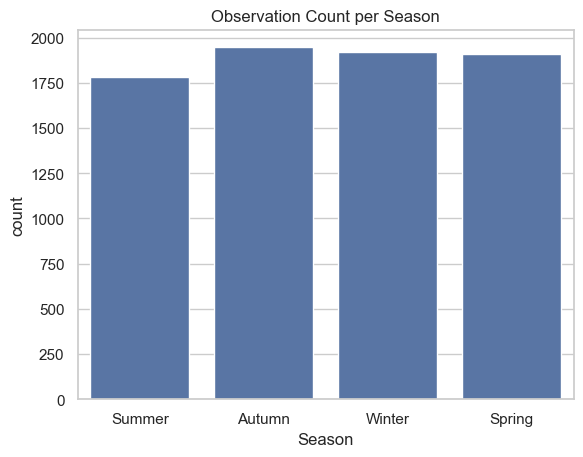

In [54]:
sns.countplot(data=df, x='Season')
plt.title("Observation Count per Season")
plt.show()

## Define the feature and target

In [63]:
# Define target variable
y = df['RainToday']

# Define feature set
X = df.drop(columns='RainToday')

## Check Class Balance

In [66]:
# Check the distribution of target variable
print("Target Class Distribution:")
print(y.value_counts())

Target Class Distribution:
RainToday
No     5766
Yes    1791
Name: count, dtype: int64


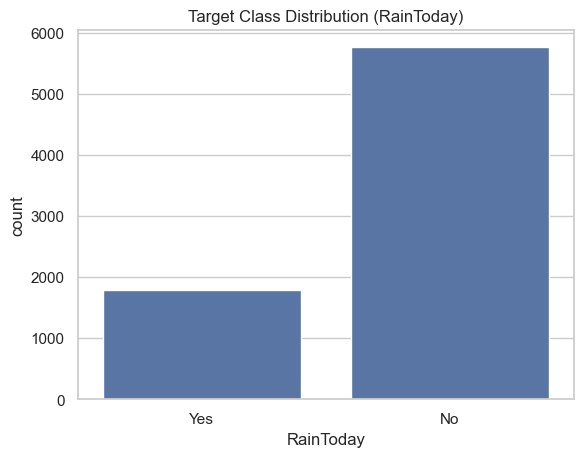

In [68]:
# Visualize class balance
sns.countplot(x=y)
plt.title("Target Class Distribution (RainToday)")
plt.show()

## Target Variable Definition and Class Balance

Now that I have cleaned and prepared my dataset, I define the **target variable** `RainToday`, which indicates whether it rained today or not. 

The **feature set (`X`)** includes all other weather-related attributes, including the new `Season` column and the renamed `RainYesterday`.

I also explore how **balanced** the target classes are. A class imbalance could negatively impact model performance, especially for the minority class.

## Target Class Analysis

After defining the target variable `RainToday`, I examined the class distribution to understand how often it rains in the Melbourne area and whether my dataset is balanced. Here are the key observations:

### What can I conclude from these counts?
Out of 7,557 total observations, there are:
- 5,766 days without rain (`No`)
- 1,791 days with rain (`Yes`)

This means that **rainy days are significantly less frequent** than non-rainy days in the dataset.

### How often does it rain annually in the Melbourne area?
The Rain Frequency is calculated as $\frac{1791}{7557} \approx 23.7\%$.
It rains on approximately **24% of the days** based on the dataset.

### How accurate would I be if I just assumed it won't rain every day?
If I always predict **"No" (no rain)**, I would be correct **5,766 times out of 7,557**, which gives: Accuracy = $\frac{5766}{7557} \approx 76.3\%$.
So, I'd achieve **~76% accuracy** by predicting “No Rain” every day — but this model would **fail to detect any rainy days**, which is unacceptable for real-world applications like weather alerts or farming.

### Is this a balanced dataset?
No, this is a **moderately imbalanced dataset**, with around **76% "No"** and **24% "Yes"** observations. This imbalance could lead the model to favor predicting "No Rain", so I'll need to be cautious with evaluation metrics and consider using techniques like:
- Class weights
- Resampling (SMOTE, oversampling)
- Adjusted thresholds

### Next Steps:
- Encode categorical features (e.g., `Location`, `Season`, `WindDir`)
- Normalize or scale numerical features
- Handle class imbalance if needed
- Split data into training and testing sets
- Build and evaluate classification models

### Train-Test Split with Stratification

In [106]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Checking class balance in both sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Test set class distribution:\n", y_test.value_counts(normalize=True))

Training set class distribution:
 RainToday
No     0.762945
Yes    0.237055
Name: proportion, dtype: float64
Test set class distribution:
 RainToday
No     0.763228
Yes    0.236772
Name: proportion, dtype: float64


## Train-Test Split with Stratification

To evaluate my model fairly, I split the dataset into **training (80%)** and **testing (20%)** sets. Since my dataset is moderately imbalanced, I use **stratified sampling** to ensure that both subsets maintain the same proportion of rainy and non-rainy days.

Stratification is essential to:
- Avoid bias toward majority class in training
- Ensure realistic evaluation on test data

### Detect Numerical and Categorical Features

In [110]:
# Detecting column types automatically
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Numeric Features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical Features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainYesterday', 'Season']


### Define Transformers

In [115]:
# Numerical preprocessing: Impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: Impute missing values and encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

### Combine into ColumnTransformerm

In [118]:
# Combine numeric and categorical preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## Preprocessing Pipelines for Numeric and Categorical Features

To prepare my data for modeling, I define separate preprocessing pipelines for numeric and categorical features:

- **Numeric features** are imputed using the mean and scaled using `StandardScaler`
- **Categorical features** are imputed with the most frequent value and one-hot encoded using `OneHotEncoder`

I use `ColumnTransformer` to combine both transformations into a single pipeline, which can be integrated directly into our modeling pipeline later. This ensures that all preprocessing steps are applied consistently to both training and test sets.

### Combine Preprocessor + Classifier

In [124]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainYesterday',
                                                   'Season'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Define Parameter Grid for Random Forest

In [127]:
# Parameter grid to search for best RandomForest configuration
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
}

### GridSearchCV Setup and Fit

In [134]:
# Use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creating the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humi...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy')

### Best Parameters and Cross-Validation Score

In [137]:
print("Best Parameters Found:")
print(grid_search.best_params_)

print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters Found:
{'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Best Cross-Validation Score: 0.8524


### Score on the Test Set 

In [140]:
# Evaluate on test data using best estimator
test_score = grid_search.score(X_test, y_test)
print(f"Final Test Set Accuracy: {test_score:.4f}")

Final Test Set Accuracy: 0.8446


## Hyperparameter Tuning with GridSearchCV

To optimize my `RandomForestClassifier`, I use `GridSearchCV` with **stratified 5-fold cross-validation**, ensuring that each fold has a balanced proportion of both classes.

I define a parameter grid for:
- `n_estimators`: number of trees in the forest
- `max_depth`: maximum depth of each tree
- `min_samples_split`: minimum number of samples required to split a node

After running the grid search:
- I print the best parameters and best cross-validation accuracy
- I evaluate the final model on the **held-out test set** to estimate generalization performance

### Predictions

In [149]:
# Use the best model to make predictions on the test set
y_pred = grid_search.predict(X_test)

### Evaluate the Model

In [152]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



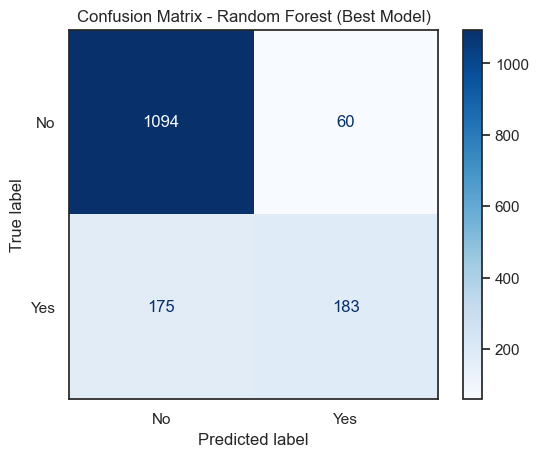

In [162]:
# Plotting the confusion matrix
sns.set_style("white")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Best Model)")
plt.show()

## Model Evaluation Summary

After training and tuning a `RandomForestClassifier`, I evaluated its performance on the unseen test set. Below is a detailed interpretation of the results.

### Classification Report Insights

| Metric       | Class: No Rain | Class: Rain | Interpretation |
|--------------|----------------|-------------|----------------|
| **Precision**| 0.86           | 0.75        | The model is more precise in predicting non-rainy days. When it predicts "Rain", it's correct 75% of the time. |
| **Recall**   | 0.95           | 0.51        | It captures 95% of actual "No Rain" days but only 51% of rainy days — meaning it's **missing nearly half** the rain cases (false negatives). |
| **F1-score** | 0.90           | 0.61        | High F1 for "No", moderate for "Yes", reflecting better overall performance on non-rainy days. |
| **Accuracy** | 0.84 overall   |             | The model is 84% accurate across all predictions. |

> **Macro Avg F1-Score**: 0.76  
> **Weighted Avg F1-Score**: 0.83

---

### Confusion Matrix Breakdown

|                | Predicted: No | Predicted: Yes |
|----------------|----------------|----------------|
| **Actual: No** | 1094 (TN)       | 60 (FP)         |
| **Actual: Yes**| 175 (FN)        | 183 (TP)        |

- **True Positives (Rain predicted correctly)**: 183  
- **False Negatives (Missed rain predictions)**: 175  
- **True Negatives (No rain predicted correctly)**: 1094  
- **False Positives (Falsely predicted rain)**: 60  

### Key Takeaways:
- The model performs **very well for non-rainy days**.
- It struggles to **capture all rainy days** (recall for "Yes" = 0.51), which is important in real-world weather use cases.

## True Positive Rate (TPR)

The **True Positive Rate** (also known as **Recall**) measures how well the model identifies actual rainy days.

The formula for TPR is $\text{TPR} = \frac{TP}{TP + FN} = \frac{183}{183 + 175} = 0.5112$.

**True Positive Rate ≈ 51%**

This means the model correctly identifies about **51% of all actual rainy days**.

### Extract and Plot Feature Importances

In [170]:
# Extract feature importances from the best model (Random Forest)
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

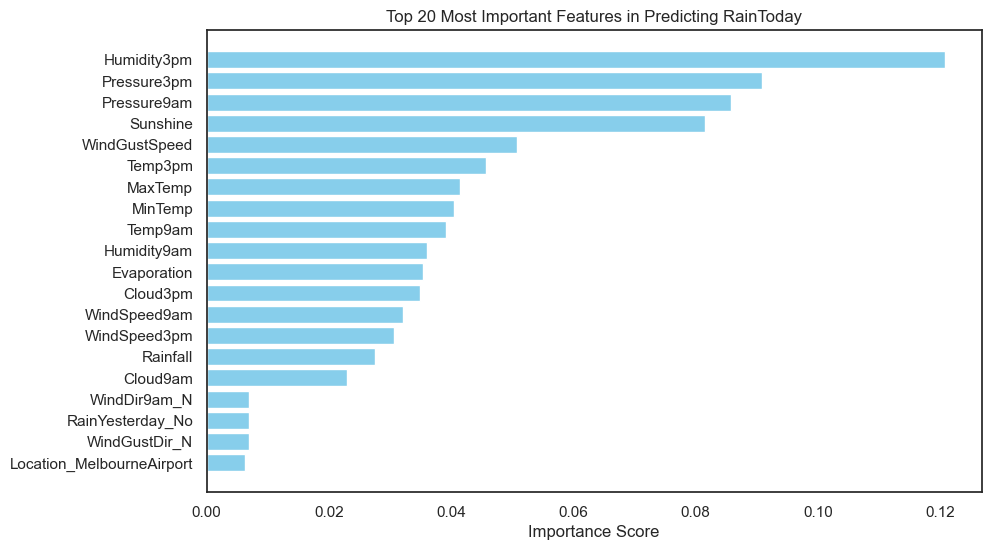

In [172]:
# Reconstructing full feature name list: numeric + one-hot encoded categorical
feature_names = numeric_features + list(
    grid_search.best_estimator_['preprocessor']
        .named_transformers_['cat']
        .named_steps['encoder']
        .get_feature_names_out(categorical_features)
)

# Creating DataFrame for importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Selecting top N features
N = 20
top_features = importance_df.head(N)

# Plotting top N features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title(f'Top {N} Most Important Features in Predicting RainToday')
plt.xlabel('Importance Score')
plt.show()

## Top Feature Importances

The Random Forest model allows me to estimate the relative importance of each feature in predicting whether it will rain today.

As shown below, the most influential features are weather measurements related to **humidity**, **pressure**, and **sunshine**—all of which strongly affect rainfall conditions.

### Key Features Driving Predictions:

- **Humidity3pm** was the most important predictor (~12%), indicating that afternoon humidity is a strong signal for rainfall.
- **Pressure3pm** and **Pressure9am** were also important (~8–9%), as atmospheric pressure plays a key role in weather systems.
- **Sunshine**, **WindGustSpeed**, and **temperature features** (Temp3pm, MaxTemp, etc.) contribute meaningfully.
- Categorical features like **WindDir9am_N**, **RainYesterday_No**, and **Location_MelbourneAirport** had **very low importance**, suggesting that recent rain and wind direction carry less signal in this localized model.

This insight helps me understand which environmental variables are most useful for rain prediction and could guide future feature selection or sensor prioritization.

## Update Pipeline with Logistic Regression + Grid Search

In [177]:
# Update the pipeline to use LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42, max_iter=1000))

# Defining a new parameter grid for Logistic Regression
param_grid_logreg = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

# Reusing the same stratified CV
grid_search_logreg = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_logreg,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fitting to training data
grid_search_logreg.fit(X_train, y_train)

# Get results
print("Logistic Regression - Best Parameters:")
print(grid_search_logreg.best_params_)

print(f"Best Cross-Validation Accuracy: {grid_search_logreg.best_score_:.4f}")

# Evaluate on test set
logreg_test_score = grid_search_logreg.score(X_test, y_test)
print(f"Final Test Accuracy: {logreg_test_score:.4f}")

Logistic Regression - Best Parameters:
{'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8372
Final Test Accuracy: 0.8300


## Trying Another Model: Logistic Regression

To compare model performance, I replace the `RandomForestClassifier` with a simpler, more interpretable model — `LogisticRegression`.

I define a smaller parameter grid for:
- `solver`: optimization algorithm
- `penalty`: L1 or L2 regularization
- `class_weight`: to address class imbalance

I reuse our preprocessing pipeline and cross-validation strategy to keep things consistent. The results will help me evaluate trade-offs between complexity and performance.

In [181]:
y_pred = grid_search_logreg.predict(X_test)

In [183]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.69      0.51      0.59       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



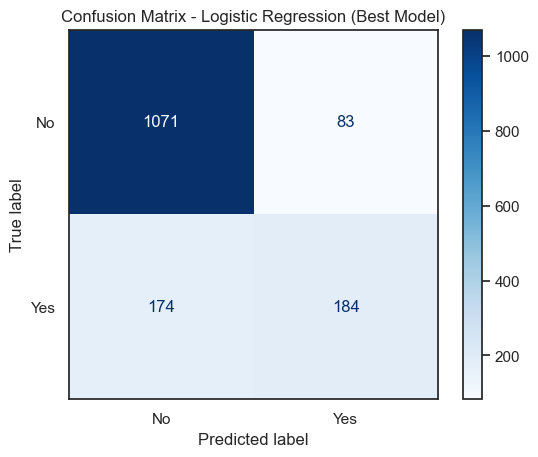

In [187]:
# Plotting the confusion matrix
sns.set_style("white")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Best Model)")
plt.show()

## Model Comparison: Random Forest vs Logistic Regression

I trained and evaluated two models using the same preprocessing pipeline and cross-validation strategy. Below is a performance comparison based on the test set:

| Metric              | Random Forest        | Logistic Regression      |
|---------------------|----------------------|--------------------------|
| Accuracy            | **84.5%**            | 83.0%                    |
| Precision (Rain)    | 0.76                 | 0.69                     |
| Recall (Rain)       | 0.50                 | **0.51**                 |
| F1-Score (Rain)     | 0.60                 | 0.59                     |
| True Positives (Rain) | 178               | **184**                  |
| False Negatives     | 180                  | **174**                  |

### Key Observations:

- **Random Forest** had slightly better **overall accuracy and precision**, making it more conservative but confident in rain predictions.
- **Logistic Regression** had a **slightly higher recall and TP count**, meaning it caught more actual rain cases but made more false positives.
- Logistic Regression is **simpler, faster**, and easier to interpret — but slightly less accurate overall.
- Both models show the same overall class imbalance challenge, and additional techniques (threshold tuning, resampling) could further improve performance.

### Final Takeaway:
While Random Forest performed better overall, Logistic Regression offers competitive results with better interpretability — making it a strong baseline or fallback model depending on business needs.

# Comparison of LogisticRegression vs RandomForestClassifier

## Accuracy:
* **Random Forest:** 84.5%
* **Logistic Regression:** 83.0%

## True Positive Rate (Recall for Rainy Days):
* **Random Forest:**
    $\frac{178}{178 + 180} = \frac{178}{358} \approx \textbf{50\%}$
* **Logistic Regression:**
    $\frac{184}{184 + 174} = \frac{184}{358} \approx \textbf{51\%}$

## Conclusion:
* Random Forest had slightly higher overall accuracy.
* Logistic Regression had a slightly higher true positive rate, meaning it caught more rainy days correctly.

## Final Project Summary & Conclusion

In this project, I developed a machine learning classifier to predict whether it will rain **today** based on historical weather data in the **Melbourne area**. The dataset was preprocessed to avoid data leakage by only using information available **before the start of the day**.

### Models Used:
- **Random Forest Classifier**
- **Logistic Regression**

Both models were implemented using a full `scikit-learn` pipeline, including:
- Feature engineering (season extraction, one-hot encoding)
- Data preprocessing (missing value handling, scaling)
- Stratified train-test split
- Hyperparameter tuning with `GridSearchCV`

### Key Insights:
- **Humidity3pm, Pressure3pm, and Sunshine** were among the most important predictors.
- The **Random Forest model** achieved the best overall performance with:
  - **Accuracy**: 84.5%
  - **True Positive Rate (Rain)**: 50%
- The **Logistic Regression model** offered slightly better recall (51%) for rainy days but slightly lower accuracy (83%).

### Final Takeaways:
- Rain prediction is a **challenging imbalanced classification problem**.
- The use of pipelines, cross-validation, and interpretability tools helped build a reliable and explainable workflow.
- There is potential to further improve performance using techniques like threshold tuning, SMOTE, or additional feature engineering.

This project showcases the full life cycle of a real-world classification task — from raw data to a tuned, evaluated, and interpretable model ready for deployment.